In [3]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [6]:
# Create directory if not existL
try:
    data_mask.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print("Image Mask folder is already there")
else:
    print("Image Mask folder was created")

info_csv = data_meta / "all_info.csv"

Image Mask folder was created


In [7]:
DEFAULT_CHANNELS = (1, 2, 3)

RGB_MAP = {
    1: {"rgb": np.array([255, 0, 0]), "range": [0, 60]},
    2: {"rgb": np.array([0, 255, 0]), "range": [0, 255]},
    3: {"rgb": np.array([0, 0, 255]), "range": [0, 100]},
}


def convert_to_rgb(t, channels=DEFAULT_CHANNELS, vmax=255, rgb_map=RGB_MAP):
    """
    Converts and returns the image data as RGB image
    Parameters
    ----------
    t : np.ndarray
        original image data
    channels : list of int
        channels to include
    vmax : int
        the max value used for scaling
    rgb_map : dict
        the color mapping for each channel
        See rxrx.io.RGB_MAP to see what the defaults are.
    Returns
    -------
    np.ndarray the image data of the site as RGB channels
    """
    dim1, dim2, _ = t.shape
    colored_channels = []
    for i, channel in enumerate(channels):
        x = (t[:, :, channel - 1] / vmax) / (
            (rgb_map[channel]["range"][1] - rgb_map[channel]["range"][0]) / 255
        ) + rgb_map[channel]["range"][0] / 255
        x = np.where(x > 1.0, 1.0, x)
        x_rgb = np.array(
            np.outer(x, rgb_map[channel]["rgb"]).reshape(dim1, dim2, 3), dtype=int
        )
        colored_channels.append(x_rgb)
    im = np.array(np.array(colored_channels).sum(axis=0), dtype=int)
    im = np.where(im > 255, 255, im)
    im = im.astype(np.uint8)
    return im

In [8]:
# Read dataframe containing images information
df = pd.read_csv(info_csv)

In [9]:
def get_composite_image(df, seg_cycle="2seg"):
    # Read condition and cycles name
    conditions = df.Condition.unique()
    imgs = []

    for condition in conditions:
        df_subset = df[
            (df.Condition == condition)
            & (df.Cycle == seg_cycle)
            & (df.Z_stack == "Combined")
        ]

        dapi_path = df_subset[df_subset.Marker == "DAPI"].Path_corrected.item()
        pha_path = df_subset[df_subset.Marker == "Phalloidin"].Path_corrected.item()
        wga_path = df_subset[df_subset.Marker == "WGA"].Path_corrected.item()

        img_dapi = skimage.io.imread(dapi_path)
        img_pha = skimage.io.imread(pha_path)
        img_wga = skimage.io.imread(wga_path)

        data = np.concatenate(
            (
                img_pha[:, :, np.newaxis],
                img_wga[:, :, np.newaxis],
                img_dapi[:, :, np.newaxis],
            ),
            axis=2,
        )
        img = convert_to_rgb(data, vmax=65536)
        imgs.append(img)

    return imgs, conditions

In [10]:
imgs, conditions = get_composite_image(df)

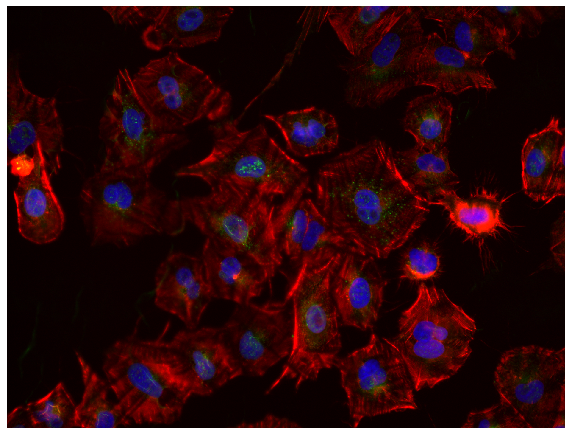

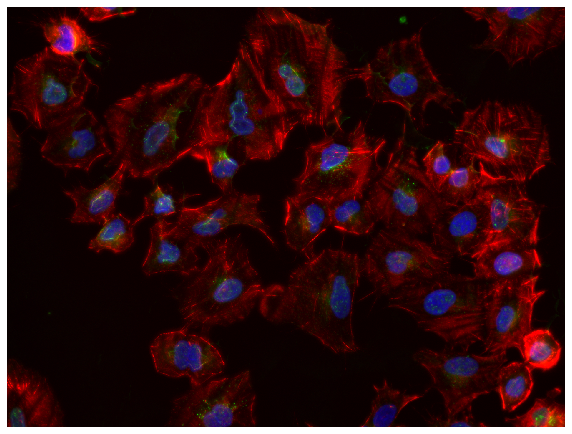

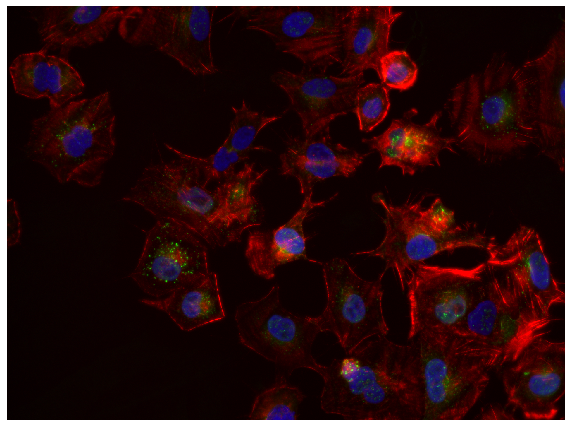

In [11]:
for img in imgs:
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)

# Segmentation with cellpose

In [12]:
def save_mask(masks, conditions, folder, cyto=True):
    for idx in range(len(masks)):
        if cyto:
            filename = "_".join([conditions[idx], "cyto_masks"])
        else:
            filename = "_".join([conditions[idx], "nuclei_masks"])
        path = os.path.join(folder, filename + ".tiff")
        cv2.imwrite(path, masks[idx])

** CUDA version installed and working. **
GPU activated? 1
cellpose_residual_on_style_on_concatenation_off
processing 3 image(s)
100%|██████████| 3/3 [00:06<00:00,  2.30s/it]
time spent: running network 4.88s; flow+mask computation 1.93
estimated masks for 3 image(s) in 7.80 sec
>>>> TOTAL TIME 7.80 sec


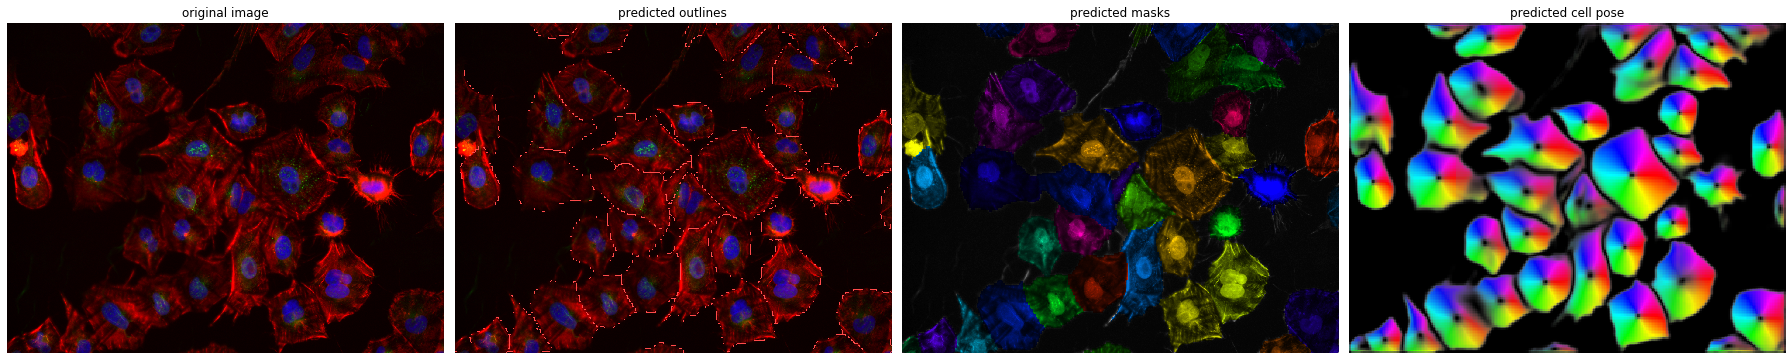

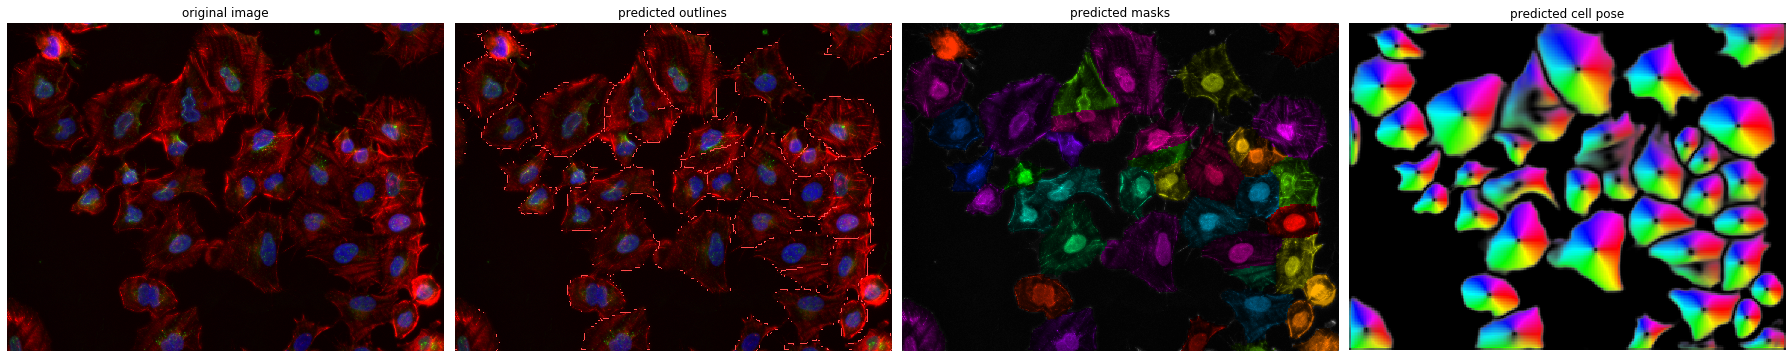

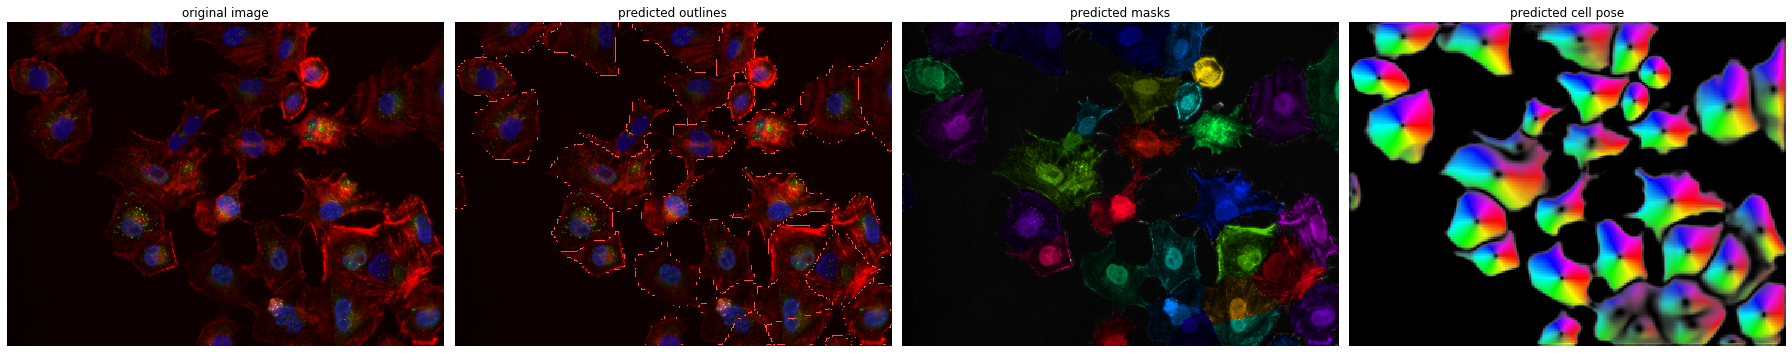

In [13]:
import mxnet as mx
from cellpose import utils

use_GPU = utils.use_gpu()
print("GPU activated? %d" % use_GPU)

# DISPLAY RESULTS
from cellpose import models, plot

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type="cyto", device=mx.gpu(0))

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [1, 3]

masks, flows, styles, diams = model.eval(
    imgs, diameter=200, flow_threshold=None, channels=channels
)

nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(25, 15))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    #     plt.savefig(str(idx)+'.png')
    plt.show()

In [14]:
save_mask(masks, conditions, data_mask)

## Nuclei channel segmentation

In [15]:
imgs_nuclei = [img[:, :, 2] for img in imgs]

cellpose_residual_on_style_on_concatenation_off
processing 3 image(s)
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
time spent: running network 1.32s; flow+mask computation 0.63
estimated masks for 3 image(s) in 2.57 sec
>>>> TOTAL TIME 2.57 sec


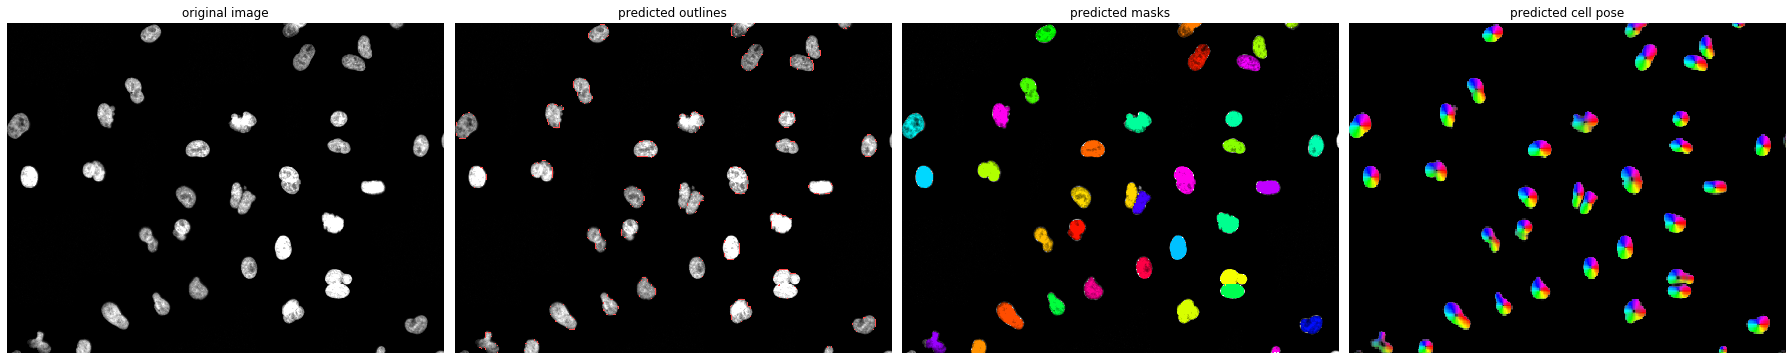

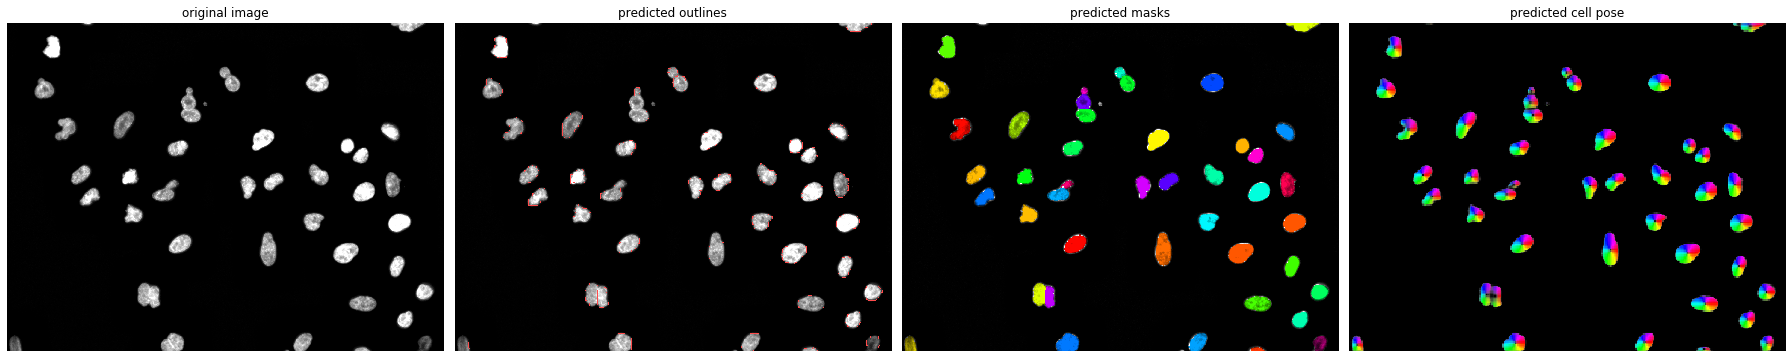

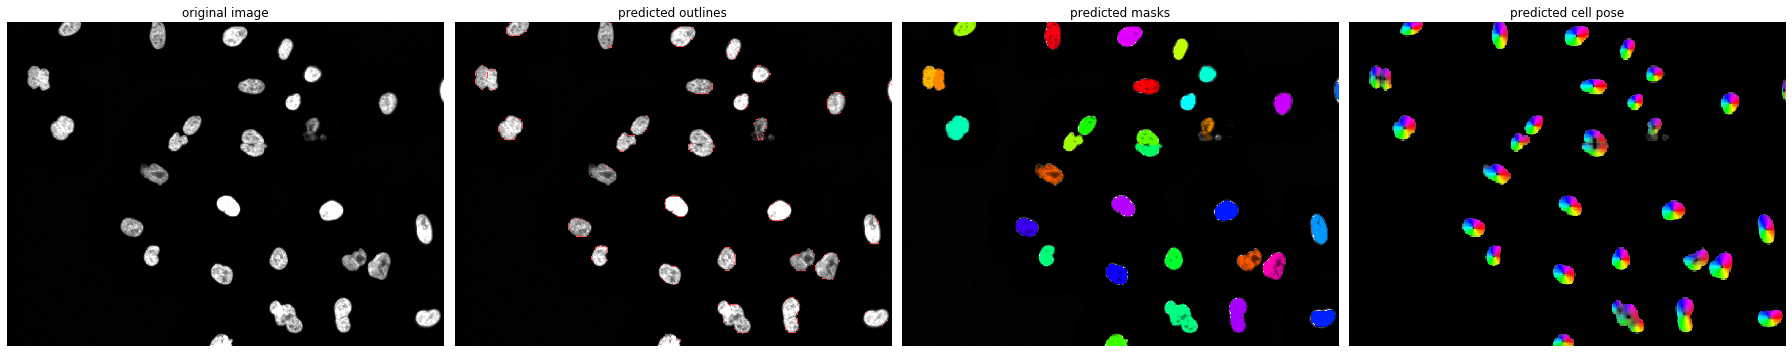

In [16]:
# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type="nuclei", device=mx.gpu(0))

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [0, 0]

masks, flows, styles, diams = model.eval(
    imgs_nuclei, diameter=100, flow_threshold=None, channels=channels
)

nimg = len(imgs_nuclei)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(25, 15))
    plot.show_segmentation(fig, imgs_nuclei[idx], maski, flowi, channels=channels)
    plt.tight_layout()
    #     plt.savefig(str(idx)+'.png')
    plt.show()

In [17]:
save_mask(masks, conditions, data_mask, cyto=False)